In [1]:
## imports
import matplotlib.pyplot as plt
from src.plot_utils import *
from src.sim_utils import *
import yaml
import numpy as np
import jax.numpy as jnp
import sparse
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from pathlib import Path, PosixPath
import h5py

In [2]:
## plotting defaults
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["axes.spines.right"] = "False"
plt.rcParams["axes.spines.top"] = "False"
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["figure.figsize"] = (2,2)
plt.rcParams['axes.linewidth'] = 0.25
plt.rcParams["xtick.major.size"] = 1.7
plt.rcParams["ytick.major.size"] = 1.7
plt.rcParams["xtick.major.width"] = 0.25
plt.rcParams["ytick.major.width"] = 0.25
plt.rcParams["figure.dpi"] = 200

SMALL_SIZE = 6
LABEL_SIZE = 7
AXLABEL_SIZE = 8
TITLE_SIZE = 10

plt.rcParams["font.family"] = "Arial" # "Arial"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXLABEL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LABEL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

plt.rcParams["axes.labelpad"] = 1.5
plt.rcParams["xtick.major.pad"] = 1.5
plt.rcParams["ytick.major.pad"] = 1.5

moduleColors = get_module_colors()

dnColor = "#51bbad"
excColor = "#d84a2e"
inhColor = "#026b85"
mnColor = "#267655"

lightDnColor = "#a7dcd5ff"
lightExcColor = "#ff9985"

dataPath = "/data/users/smpuglie/Pugliese_2025/"

In [3]:
simType = "DNg100_Stim"
simPath = simType+"/hyak/run_id=28934519"
folder = dataPath + simPath
overallParams = DictConfig(load_from_yaml(folder+"/multirun.yaml"))
wTable = pd.read_csv("../"+overallParams.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])

nSims = overallParams.experiment.n_replicates
nActive = pd.DataFrame(index=np.arange(nSims))
nMnsActive = pd.DataFrame(index=np.arange(nSims))
simScore = pd.DataFrame(index=np.arange(nSims))
mnFreq = pd.DataFrame(index=np.arange(nSims))

subfolders = []
for f in os.listdir(folder):
    if os.path.isdir(f"{folder}/{f}"):
        subfolders.append(f)

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


In [4]:
for subfolder in subfolders:
    print(f"Loading {subfolder}")
    Rs = sparse.load_npz(folder+f"/{subfolder}/ckpt/{simType}_Rs.npz").todense()
    dataset = 0
    Rs = Rs[dataset]
    params = DictConfig(load_from_yaml(folder+f"/{subfolder}/.hydra/config.yaml"))
    tauMean = params.neuron_params.tauMean
    for i in range(nSims):
        # active neurons
        R = Rs[i]
        
        activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
        nMnsActive.loc[i,tauMean] = np.sum(activeMnsMask)
        activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
        score, freq = compute_oscillation_score(R[...,250:],activeMnsMaskPastTransient)
        simScore.loc[i,tauMean] = score
        mnFreq.loc[i,tauMean] = freq

figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

nMnsActive = nMnsActive.transpose().sort_index().transpose()
simScore = simScore.transpose().sort_index().transpose()
mnFreq = mnFreq.transpose().sort_index().transpose()

Loading experiment.n_replicates=512,experiment.seed=729,neuron_params.tauMean=0.035
Loading experiment.n_replicates=512,experiment.seed=729,neuron_params.tauMean=0.03
Loading experiment.n_replicates=512,experiment.seed=729,neuron_params.tauMean=0.015
Loading experiment.n_replicates=512,experiment.seed=729,neuron_params.tauMean=0.005
Loading experiment.n_replicates=512,experiment.seed=729,neuron_params.tauMean=0.01
Loading experiment.n_replicates=512,experiment.seed=729,neuron_params.tauMean=0.02
Loading experiment.n_replicates=512,experiment.seed=729,neuron_params.tauMean=0.025


/tmp/ipykernel_1277244/3115014327.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["{:.3f}".format(s) for s in mnFreq.iloc[:,1:].columns])


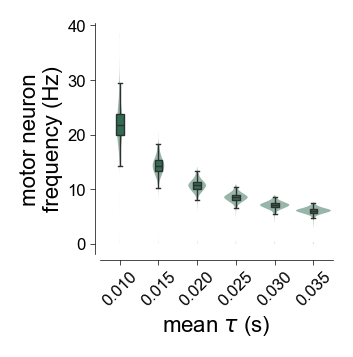

In [37]:
plt.figure(figsize=(1.5,1.5))
sns.violinplot((mnFreq/overallParams.sim.dt).iloc[:,1:].astype(float).melt(var_name="tauMean",value_name="frequency"),x="tauMean",y="frequency",edgecolor=None,inner=None,cut=0,alpha=0.5,color=mnColor,width=0.9)
sns.boxplot((mnFreq/overallParams.sim.dt).iloc[:,1:].astype(float).melt(var_name="tauMean",value_name="frequency"),x="tauMean",y="frequency",width=0.2,linewidth=0.5,fliersize=2**0.75,
            boxprops={"alpha":1.0,},showfliers=False,color=mnColor)
plt.gca().tick_params(axis='x', labelrotation=45)
sns.despine(offset=2)

plt.gca().set_xticklabels(["{:.3f}".format(s) for s in mnFreq.iloc[:,1:].columns])

plt.xlabel(r"mean $\tau$ (s)")
plt.ylabel("motor neuron\nfrequency (Hz)")
# plt.gcf().set_dpi(500)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+f"/mnFreqViolin.svg",transparent=True)
plt.show()

/tmp/ipykernel_1277244/1899686585.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(["{:.3f}".format(s) for s in simScore.iloc[:,1:].columns])


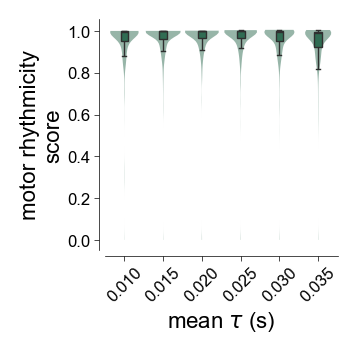

In [44]:
plt.figure(figsize=(1.5,1.5))
sns.violinplot(simScore.iloc[:,1:].astype(float).melt(var_name="tauMean",value_name="frequency"),x="tauMean",y="frequency",edgecolor=None,inner=None,cut=0,alpha=0.5,color=mnColor,width=0.9)
sns.boxplot(simScore.iloc[:,1:].astype(float).melt(var_name="tauMean",value_name="frequency"),x="tauMean",y="frequency",width=0.2,linewidth=0.5,fliersize=2**0.75,
            boxprops={"alpha":1.0,},showfliers=False,color=mnColor)
plt.gca().tick_params(axis='x', labelrotation=45)
sns.despine(offset=2)

plt.gca().set_xticklabels(["{:.3f}".format(s) for s in simScore.iloc[:,1:].columns])

plt.xlabel(r"mean $\tau$ (s)")
plt.ylabel("motor rhythmicity\nscore")
# plt.gcf().set_dpi(500)

if not os.path.exists(figFolder):
    os.makedirs(figFolder)
plt.savefig(figFolder+f"/simScoreViolin.svg",transparent=True)
plt.show()

In [41]:
if not os.path.exists(figFolder):
    os.makedirs(figFolder)
nMnsActive.to_csv(figFolder+"/nMnsActive.csv")
simScore.to_csv(figFolder+"/scores.csv")
mnFreq.to_csv(figFolder+"/frequencies.csv")